**This is largely based on Andrej Karpathy's guide to GPT-2 tokenization:** https://www.youtube.com/watch?v=zduSFxRajkE&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=10&ab_channel=AndrejKarpathy  

# Why Tokenization?

## Idea 1: Why not just use words?

Only ~1/2 the natural languge on the internet is English. An LLM needs to handle any internet information in training/deployment.

This includes: programming syntax, URLs, image files, misc. data files, random Unicode.

Can try to make special cases for all these. Doesn't end well.

Need a *general* way to handle arbitrary Unicode bytes.

E.g. try this on https://tiktokenizer.vercel.app/?model=gpt2

```
Egg.
I have an Egg.
egg.
EGG.


만나서 반가워요. 저는 OpenAI에서 개발한 대규모 언어 모델인 ChatGPT입니다. 궁금한 것이 있으시면 무엇이든 물어보세요.


for i in range(1, 101):
    if i % 3 == 0 and i % 5 == 0:
        print("FizzBuzz")
    elif i % 3 == 0:
        print("Fizz")
    elif i % 5 == 0:
        print("Buzz")
    else:
        print(i)


https://tiktokenizer.vercel.app/?model=gpt2
https://www.youtube.com/watch?v=zduSFxRajkE&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=10&ab_channel=AndrejKarpathy


⅋Ⓢ✊★⌹⤬❻ⶅ⌵⾐℮⚇⛢⪒ⅵ⇗⹈⌜⽔≛┖ⴊ⫘⭏⼏ⅿ✨⥰⭵⪿□⣇ⴑ⩷⯎⪰⎫⣛␽⿄⮌⽬⒃⥜ⵄ┨⯕ⲛ⁷⩭⛷⧤∇⽆Ɑ⢕♬ℷ⠤ⷣⳃ⽪⧂⡶➔⃲␭⡪⌈◑≇⺄◮⍜⧒➮⭪┉⩟␈ⵜⷋ␕⻅⒦⧄Ⓢ⪬⣔⭕⪜⎊≫⯹⹞⫆⪮⵺ⲽ⓫
```

## Interlude: About Unicode

Unicode explainer: https://www.reedbeta.com/blog/programmers-intro-to-unicode/  
BMP Overview: https://en.wikipedia.org/wiki/Plane_(Unicode)#Basic_Multilingual_Plane 

_ASCII_ is a set of $128 = 2^7$ characters that pretty much represents an English keyboard: 52 upper/lowercase letters, digits 0-9, various punctuation marks, and a bunch of non-printable characters like space, newline, and EOF. A character's index in such a table is called its _code point_, while its visual representation is called its _glyph_.

_Unicode_ was started in the 1980's to recognize characters from different languages in a _uni_form way. Originally, this had $65,536 = 2^{16}$ code points, now this is just considered Plane 0 of Unicode, the _Basic Multilingual Plane (BMP)_ because it still contains the majority of characters actually used. In total Unicode has 17 planes for a total of $17 * 65536 \approx$ 1.1 million code points. Most of these are still unallocated, and this usually gets updated yearly: since the last update in Sept. 2024, Unicode has 154,998 allocated code points.

Python3 Unicode HOWTO: https://docs.python.org/3/howto/unicode.html

In Python3, we can use $\texttt{chr(i : int)}$ to obtain the glyph of Unicode code point $\texttt{i}$.  
Conversely, $\texttt{ord(c : char)}$ will return the Unicode code point of a character $\texttt{c}$.  

In [1]:
# obtain glyph of Squidward's house
chr(128511)

'🗿'

In [2]:
# obtain code point of Squidward's house
ord('🗿')

128511

In [3]:
s = "안녕하세요 👋 (hello in Korean!)"
print([ord(c) for c in s])

[50504, 45397, 54616, 49464, 50836, 32, 128075, 32, 40, 104, 101, 108, 108, 111, 32, 105, 110, 32, 75, 111, 114, 101, 97, 110, 33, 41]


In [4]:
# UTF-8 is the default format here
print(s.encode('utf-8'))
print(s.encode())

b'\xec\x95\x88\xeb\x85\x95\xed\x95\x98\xec\x84\xb8\xec\x9a\x94 \xf0\x9f\x91\x8b (hello in Korean!)'
b'\xec\x95\x88\xeb\x85\x95\xed\x95\x98\xec\x84\xb8\xec\x9a\x94 \xf0\x9f\x91\x8b (hello in Korean!)'


In [5]:
# list() will print the bytes better
print(list(s.encode()))

[236, 149, 136, 235, 133, 149, 237, 149, 152, 236, 132, 184, 236, 154, 148, 32, 240, 159, 145, 139, 32, 40, 104, 101, 108, 108, 111, 32, 105, 110, 32, 75, 111, 114, 101, 97, 110, 33, 41]


In [6]:
# in UTF-8, any ASCII char (Unicode 0-127) is only 1 byte
# but the Korean and emoji chars here take multiple bytes:
len(s),len(s.encode())

(26, 39)

## About UTF-8

https://en.wikipedia.org/wiki/UTF-8#Description

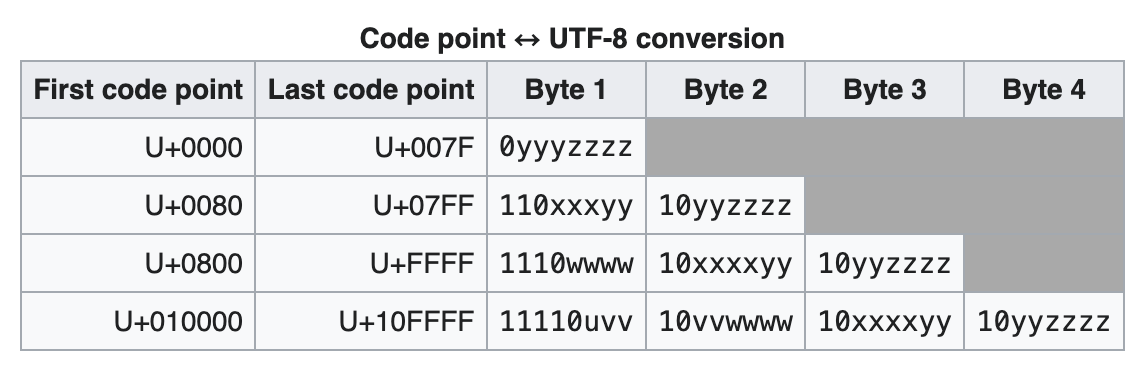

UTF-8 is the most common way to encode Unicode code points:
- 1 byte: The 128 ASCII characters
- 2 bytes: 1920 other common characters
- 3 bytes: The rest of Basic Multilingual Plane
- 4 bytes: The rest of Unicode

## Idea 2: Why not just use bytes?

This would technically work. It just wouldn't be as efficient.
- Recall "word" embeddings: these rely on the tokens being semantically meaningful.
- *Can* build a char-LLM, it would just waste a few early attention layers combining character-embeddings into semantically meaningful chunks.

## Idea 3: Byte Pair Encoding (BPE)

A middle ground between Ideas (1-2) that minimizes weaknesses of each:
- BPE is a general compression algorithm: it handles edge cases gracefully
- On common languages, it will usually tokenize into words or morphemes (e.g. "un | break | able")

**Vocab Sizes**

The following represent the extremes (more or less) among publicly released vocab sizes of modern LLMs:

GPT-2:   50,257 tokens  
GPT-4o: 199,997 tokens

In general larger models will have higher vocab sizes. The point is that 50k-200k is the ballpark we want to aim at for training an LLM.

Pigeonhole principle: some rarer characters like ⌹ will take 4 tokens to represent. This is ok!

# Byte Pair Encoding (BPE) algorithm

Let's first look at the simple example from [Wikipedia](https://en.wikipedia.org/wiki/Byte_pair_encoding):

Step 0: aaabdaaabac

We look for the most common substring of length 2, which is "aa". We will greedily merge these into a new symbol, say Z, yielding:

Step 1: ZabdZabac

Now the most common substring of length 2 is "ab", so let's replace that with a Y:

Step 2: ZYdZYac

We're also allowed to merge new symbols recursively. In our case here, "ZY" is the only substring of length 2 that repeats, so let's replace it with X:

Step 3: XdXac

And now we're out of length-2 substrings that repeat, so we are forced to stop. Then our encoding is:

Z = "aa"  
Y = "ab"  
X = ZY = "aaab"

## Analysis

This algorithm was developed by software engineer Philip Gage in 1994. It is called _byte pair_ encoding because Gage's simple idea was to "replace common pairs of bytes by single bytes".

**Input:** A corpus $C$ of length $n$ over an alphabet $A = (a_1, a_2, ..., a_k)$; usually these are bytes.

**Output:** A dictionary $D = (t_1, t_2, ..., t_m)$ of tokens representing common substrings.

**BPE Algorithm:** Repeatedly merge the most common 2-byte substring into a new token. Recursively do this on token-byte, byte-token, or token-token pairs as well.
- Termination condition: Set a parameter $M$ = _num_merges_, and stop after making that many mergers.

More explicitly:
1. Initialize dictionary $D \leftarrow (t_1, t_2, ..., t_k)$ with all single-char strings.
2. Find the bigram (2-char substring) $t_i t_j$ in $C$ with the highest frequency and add it to $D$.
3. Merge: Rewrite $C$ by substituting $t_{i,j} \leftarrow t_i t_j$ where $t_{ij}$ is some new symbol.
4. Repeat steps (2-3) $M$ times.

In our case, we start with $k = 257$: this comes from 256 distinct bytes + a special end-of-text token.

Setting _num_merges_ := 50000, we get the 50257-token vocabulary of GPT-2.

Empirically, the tokens generated by these mergers tend to be common words/morphemes.

# BPE Implementation

In [4]:
from collections import defaultdict

In [5]:
def to_bytes(text : str) -> list[int]:
    # Convert text to a list of ints in range 0...255   
    return list(text.encode('utf-8'))

def to_text(ids : list[int]) -> str:
    """
    Convert a list of ints in range 0...255 to text.
    This assumes the ints are valid as UTF-8 bytes (e.g. not 128 = 10000000),
    per this table: https://en.wikipedia.org/wiki/UTF-8#Description
    """
    return ''.join([chr(idx) for idx in ids])

def pair_counts(ids : list[int]) -> dict[tuple[int,int], int]:
    """
    Count consecutive pair (bigram) frequencies in a sequence of integers.

    Args:
        ids: A list of integers in range 0...255 to analyze for consecutive pairs.

    Returns:
        A dictionary mapping integer pairs to their frequency counts.
        Each key is a tuple (i,j) representing consecutive integers from ids,
        and each value is the number of times j directly follows i in the sequence.
    """
    counts = defaultdict(int)
    for pair in zip(ids, ids[1:]):
        counts[pair] += 1
        
    return counts

def merge(ids : list[int], pair : tuple[int,int], idx : int) -> list[int]:
    """
    Replace all occurrences of a consecutive integer pair with a single integer.

    Args:
        ids: List of integers to process.
        pair: Tuple of two integers (i,j) to search for in sequence.
        idx: Integer to substitute for each occurrence of the pair.

    Returns a tuple, consisting of:
        newids: A new list where all occurrences of consecutive integers
            matching pair are replaced by idx. All other integers remain unchanged.
        merged: A boolean indicating if any merges occurred.
    """
    newids = []
    i = 0
    merged = False

    while i < len(ids):
        if i < len(ids) - 1 and ids[i] == pair[0] and ids[i+1] == pair[1]:
            newids.append(idx)
            i += 2
            merged = True
        else:
            newids.append(ids[i])
            i += 1

    return newids, merged

In [6]:
class Tokenizer:
    def __init__(self):
        self.vocab = dict()  # char/token -> ID mapping
        self.id_to_token = dict()  # ID -> char/token mapping
        self.merges = dict()  # Store merge rules (pair -> new_token)

    def create_vocab(self, text: str, num_merges: int, threshold=2, verbose=False):
        """
        Given text and number of merges to perform,
        create vocabulary by merging character pairs.

        Args:
            text: Input string
            num_merges: Number of merges to perform
        """
        if len(text) < 2:
            print("Error: text is too small too compress")
        
        # Initialize vocabulary with unique characters
        unique_chars = sorted(set(text))
        for i, char in enumerate(unique_chars):
            self.vocab[char] = i
            self.id_to_token[i] = char
        
        # Convert text to list of IDs
        ids = [self.vocab[char] for char in text]
        k = len(unique_chars) # Alphabet size; in most applications this will be 256
        next_token_id = k # New tokens will start numbering here
        
        # Perform exactly num_merges merges
        while next_token_id < num_merges + k:
            counts = pair_counts(ids)
            most_freq_pair = max(counts, key=counts.get)

            if counts[most_freq_pair] < threshold:
                break # Further merges won't get much compression
            
            # Create new token as a string
            token1,token2 = map(self.id_to_token.get, most_freq_pair)
            new_token = token1 + token2            
            
            # Add new token to vocabulary
            self.vocab[new_token] = next_token_id
            self.id_to_token[next_token_id] = new_token
            
            # Store merge rule, apple the merge throughout the text
            self.merges[most_freq_pair] = next_token_id
            ids,_ = merge(ids, most_freq_pair, next_token_id)
            next_token_id += 1
            
            # Print state after each merge (for visualization)
            if verbose:
                print("Merge:", next_token_id - k)
                print(f"Most frequent pair: {token1},{token2} -> {new_token}")
                print(f"Current tokens:", ', '.join(str(self.id_to_token[id_]) for id_ in ids))
                print()

    def merges_print(self):
        # Output self.merges, but as strings rather than IDs
        idt = self.id_to_token
        return {(idt[k[0]],idt[k[1]]):idt[v] for k,v in self.merges.items()}
    
    def encode(self, text: str) -> list[int]:
        """
        Compress text using the generated vocabulary.
        Return a list of token ids.
        """
        # Start with character-level encoding
        ids = [self.vocab[char] for char in text]
        
        # Apply merges iteratively until no more can be applied
        while True:
            merged = False
            for pair, new_id in self.merges.items():
                ids,merged = merge(ids, pair, new_id)

            if not merged:
                break
                
        return ids

    def encode_print(self, text: str) -> str:
        """
        Compress text using the generated vocabulary.
        Return a list of token strings.
        """
        return [self.id_to_token[i] for i in self.encode(text)]

    def decode(self, ids: list[int]) -> str:
        """
        Decode a sequence of token IDs back to text.
        """
        return ''.join(self.id_to_token[id_] for id_ in ids)

## 1) The Wikipedia example:

In [7]:
BPE_example = "aaabdaaabac"
T = Tokenizer()
T.create_vocab(BPE_example, num_merges=3, verbose=True)

print("\nFinal vocabulary:")
print(T.id_to_token)

# Test encoding/decoding
encoded = T.encode(BPE_example)
encoded_print = T.encode_print(BPE_example)
decoded = T.decode(encoded)
print("\nOriginal:", BPE_example)
print("Encoded:", encoded)
print("Encoded:", encoded_print)
print("Decoded:", decoded)
assert BPE_example == decoded

Merge: 1
Most frequent pair: a,a -> aa
Current tokens: aa, a, b, d, aa, a, b, a, c

Merge: 2
Most frequent pair: aa,a -> aaa
Current tokens: aaa, b, d, aaa, b, a, c

Merge: 3
Most frequent pair: aaa,b -> aaab
Current tokens: aaab, d, aaab, a, c


Final vocabulary:
{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'aa', 5: 'aaa', 6: 'aaab'}

Original: aaabdaaabac
Encoded: [6, 3, 6, 0, 2]
Encoded: ['aaab', 'd', 'aaab', 'a', 'c']
Decoded: aaabdaaabac


## 2) A 533-character example

The first paragraph of the aforementioned article about Unicode.

In [8]:
# text from https://www.reedbeta.com/blog/programmers-intro-to-unicode/
text = "Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺‌🇳‌🇮‌🇨‌🇴‌🇩‌🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception."
len(text),len(set(text))

(533, 69)

In [9]:
T = Tokenizer()
T.create_vocab(text, num_merges=100, verbose=False)

print("\nFinal vocabulary:")
print(T.id_to_token)

# Test encoding/decoding
encoded = T.encode(text)
encoded_print = T.encode_print(text)
decoded = T.decode(encoded)


Final vocabulary:
{0: ' ', 1: '!', 2: '(', 3: ')', 4: ',', 5: '-', 6: '.', 7: '0', 8: '3', 9: '?', 10: 'B', 11: 'I', 12: 'S', 13: 'T', 14: 'U', 15: 'W', 16: '_', 17: 'a', 18: 'b', 19: 'c', 20: 'd', 21: 'e', 22: 'f', 23: 'g', 24: 'h', 25: 'i', 26: 'k', 27: 'l', 28: 'm', 29: 'n', 30: 'o', 31: 'p', 32: 'r', 33: 's', 34: 't', 35: 'u', 36: 'v', 37: 'w', 38: 'x', 39: 'y', 40: 'z', 41: '\u200c', 42: '—', 43: '’', 44: '“', 45: '”', 46: '‽', 47: 'Ｕ', 48: 'ｃ', 49: 'ｄ', 50: 'ｅ', 51: 'ｉ', 52: 'ｎ', 53: 'ｏ', 54: '🅒', 55: '🅓', 56: '🅔', 57: '🅘', 58: '🅝', 59: '🅞', 60: '🅤', 61: '🇨', 62: '🇩', 63: '🇪', 64: '🇮', 65: '🇳', 66: '🇴', 67: '🇺', 68: '😄', 69: 'e ', 70: 'in', 71: 's ', 72: 'an', 73: 'th', 74: 'ar', 75: 'er', 76: 'or', 77: 't ', 78: 'ing', 79: 'st', 80: 'and', 81: ' th', 82: ', ', 83: 'am', 84: ' the ', 85: 'ou', 86: 'Un', 87: 'Uni', 88: 'Unic', 89: 'Unico', 90: 'Unicod', 91: 's, ', 92: 'str', 93: 'ear', 94: 'and ', 95: 'int', 96: 'of', 97: '. ', 98: 'll', 99: 'ing ', 100: 'an ', 101: 'en', 102: '!

## 3) A 23,000-character example

The full article about Unicode.

In [13]:
# text from https://www.reedbeta.com/blog/programmers-intro-to-unicode/
article = """A Programmer’s Introduction to Unicode March 3, 2017 · Coding · 22 Comments  Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺\u200c🇳\u200c🇮\u200c🇨\u200c🇴\u200c🇩\u200c🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception.  A few months ago, I got interested in Unicode and decided to spend some time learning more about it in detail. In this article, I’ll give an introduction to it from a programmer’s point of view.  I’m going to focus on the character set and what’s involved in working with strings and files of Unicode text. However, in this article I’m not going to talk about fonts, text layout/shaping/rendering, or localization in detail—those are separate issues, beyond my scope (and knowledge) here.  Diversity and Inherent Complexity The Unicode Codespace Codespace Allocation Scripts Usage Frequency Encodings UTF-8 UTF-16 Combining Marks Canonical Equivalence Normalization Forms Grapheme Clusters And More… Diversity and Inherent Complexity As soon as you start to study Unicode, it becomes clear that it represents a large jump in complexity over character sets like ASCII that you may be more familiar with. It’s not just that Unicode contains a much larger number of characters, although that’s part of it. Unicode also has a great deal of internal structure, features, and special cases, making it much more than what one might expect a mere “character set” to be. We’ll see some of that later in this article.  When confronting all this complexity, especially as an engineer, it’s hard not to find oneself asking, “Why do we need all this? Is this really necessary? Couldn’t it be simplified?”  However, Unicode aims to faithfully represent the entire world’s writing systems. The Unicode Consortium’s stated goal is “enabling people around the world to use computers in any language”. And as you might imagine, the diversity of written languages is immense! To date, Unicode supports 135 different scripts, covering some 1100 languages, and there’s still a long tail of over 100 unsupported scripts, both modern and historical, which people are still working to add.  Given this enormous diversity, it’s inevitable that representing it is a complicated project. Unicode embraces that diversity, and accepts the complexity inherent in its mission to include all human writing systems. It doesn’t make a lot of trade-offs in the name of simplification, and it makes exceptions to its own rules where necessary to further its mission.  Moreover, Unicode is committed not just to supporting texts in any single language, but also to letting multiple languages coexist within one text—which introduces even more complexity.  Most programming languages have libraries available to handle the gory low-level details of text manipulation, but as a programmer, you’ll still need to know about certain Unicode features in order to know when and how to apply them. It may take some time to wrap your head around it all, but don’t be discouraged—think about the billions of people for whom your software will be more accessible through supporting text in their language. Embrace the complexity!  The Unicode Codespace Let’s start with some general orientation. The basic elements of Unicode—its “characters”, although that term isn’t quite right—are called code points. Code points are identified by number, customarily written in hexadecimal with the prefix “U+”, such as U+0041 “A” latin capital letter a or U+03B8 “θ” greek small letter theta. Each code point also has a short name, and quite a few other properties, specified in the Unicode Character Database.  The set of all possible code points is called the codespace. The Unicode codespace consists of 1,114,112 code points. However, only 128,237 of them—about 12% of the codespace—are actually assigned, to date. There’s plenty of room for growth! Unicode also reserves an additional 137,468 code points as “private use” areas, which have no standardized meaning and are available for individual applications to define for their own purposes.  Codespace Allocation To get a feel for how the codespace is laid out, it’s helpful to visualize it. Below is a map of the entire codespace, with one pixel per code point. It’s arranged in tiles for visual coherence; each small square is 16×16 = 256 code points, and each large square is a “plane” of 65,536 code points. There are 17 planes altogether.  Map of the Unicode codespace (click to zoom)  White represents unassigned space. Blue is assigned code points, green is private-use areas, and the small red area is surrogates (more about those later). As you can see, the assigned code points are distributed somewhat sparsely, but concentrated in the first three planes.  Plane 0 is also known as the “Basic Multilingual Plane”, or BMP. The BMP contains essentially all the characters needed for modern text in any script, including Latin, Cyrillic, Greek, Han (Chinese), Japanese, Korean, Arabic, Hebrew, Devanagari (Indian), and many more.  (In the past, the codespace was just the BMP and no more—Unicode was originally conceived as a straightforward 16-bit encoding, with only 65,536 code points. It was expanded to its current size in 1996. However, the vast majority of code points in modern text belong to the BMP.)  Plane 1 contains historical scripts, such as Sumerian cuneiform and Egyptian hieroglyphs, as well as emoji and various other symbols. Plane 2 contains a large block of less-common and historical Han characters. The remaining planes are empty, except for a small number of rarely-used formatting characters in Plane 14; planes 15–16 are reserved entirely for private use.  Scripts Let’s zoom in on the first three planes, since that’s where the action is:  Map of scripts in Unicode planes 0–2 (click to zoom)  This map color-codes the 135 different scripts in Unicode. You can see how Han () and Korean () take up most of the range of the BMP (the left large square). By contrast, all of the European, Middle Eastern, and South Asian scripts fit into the first row of the BMP in this diagram.  Many areas of the codespace are adapted or copied from earlier encodings. For example, the first 128 code points of Unicode are just a copy of ASCII. This has clear benefits for compatibility—it’s easy to losslessly convert texts from smaller encodings into Unicode (and the other direction too, as long as no characters outside the smaller encoding are used).  Usage Frequency One more interesting way to visualize the codespace is to look at the distribution of usage—in other words, how often each code point is actually used in real-world texts. Below is a heat map of planes 0–2 based on a large sample of text from Wikipedia and Twitter (all languages). Frequency increases from black (never seen) through red and yellow to white.  Heat map of code point usage frequency in Unicode planes 0–2 (click to zoom)  You can see that the vast majority of this text sample lies in the BMP, with only scattered usage of code points from planes 1–2. The biggest exception is emoji, which show up here as the several bright squares in the bottom row of plane 1.  Encodings We’ve seen that Unicode code points are abstractly identified by their index in the codespace, ranging from U+0000 to U+10FFFF. But how do code points get represented as bytes, in memory or in a file?  The most convenient, computer-friendliest (and programmer-friendliest) thing to do would be to just store the code point index as a 32-bit integer. This works, but it consumes 4 bytes per code point, which is sort of a lot. Using 32-bit ints for Unicode will cost you a bunch of extra storage, memory, and performance in bandwidth-bound scenarios, if you work with a lot of text.  Consequently, there are several more-compact encodings for Unicode. The 32-bit integer encoding is officially called UTF-32 (UTF = “Unicode Transformation Format”), but it’s rarely used for storage. At most, it comes up sometimes as a temporary internal representation, for examining or operating on the code points in a string.  Much more commonly, you’ll see Unicode text encoded as either UTF-8 or UTF-16. These are both variable-length encodings, made up of 8-bit or 16-bit units, respectively. In these schemes, code points with smaller index values take up fewer bytes, which saves a lot of memory for typical texts. The trade-off is that processing UTF-8/16 texts is more programmatically involved, and likely slower.  UTF-8 In UTF-8, each code point is stored using 1 to 4 bytes, based on its index value.  UTF-8 uses a system of binary prefixes, in which the high bits of each byte mark whether it’s a single byte, the beginning of a multi-byte sequence, or a continuation byte; the remaining bits, concatenated, give the code point index. This table shows how it works:  UTF-8 (binary)\tCode point (binary)\tRange 0xxxxxxx\txxxxxxx\tU+0000–U+007F 110xxxxx 10yyyyyy\txxxxxyyyyyy\tU+0080–U+07FF 1110xxxx 10yyyyyy 10zzzzzz\txxxxyyyyyyzzzzzz\tU+0800–U+FFFF 11110xxx 10yyyyyy 10zzzzzz 10wwwwww\txxxyyyyyyzzzzzzwwwwww\tU+10000–U+10FFFF A handy property of UTF-8 is that code points below 128 (ASCII characters) are encoded as single bytes, and all non-ASCII code points are encoded using sequences of bytes 128–255. This has a couple of nice consequences. First, any strings or files out there that are already in ASCII can also be interpreted as UTF-8 without any conversion. Second, lots of widely-used string programming idioms—such as null termination, or delimiters (newlines, tabs, commas, slashes, etc.)—will just work on UTF-8 strings. ASCII bytes never occur inside the encoding of non-ASCII code points, so searching byte-wise for a null terminator or a delimiter will do the right thing.  Thanks to this convenience, it’s relatively simple to extend legacy ASCII programs and APIs to handle UTF-8 strings. UTF-8 is very widely used in the Unix/Linux and Web worlds, and many programmers argue UTF-8 should be the default encoding everywhere.  However, UTF-8 isn’t a drop-in replacement for ASCII strings in all respects. For instance, code that iterates over the “characters” in a string will need to decode UTF-8 and iterate over code points (or maybe grapheme clusters—more about those later), not bytes. When you measure the “length” of a string, you’ll need to think about whether you want the length in bytes, the length in code points, the width of the text when rendered, or something else.  UTF-16 The other encoding that you’re likely to encounter is UTF-16. It uses 16-bit words, with each code point stored as either 1 or 2 words.  Like UTF-8, we can express the UTF-16 encoding rules in the form of binary prefixes:  UTF-16 (binary)\tCode point (binary)\tRange xxxxxxxxxxxxxxxx\txxxxxxxxxxxxxxxx\tU+0000–U+FFFF 110110xxxxxxxxxx 110111yyyyyyyyyy\txxxxxxxxxxyyyyyyyyyy + 0x10000\tU+10000–U+10FFFF A more common way that people talk about UTF-16 encoding, though, is in terms of code points called “surrogates”. All the code points in the range U+D800–U+DFFF—or in other words, the code points that match the binary prefixes 110110 and 110111 in the table above—are reserved specifically for UTF-16 encoding, and don’t represent any valid characters on their own. They’re only meant to occur in the 2-word encoding pattern above, which is called a “surrogate pair”. Surrogate code points are illegal in any other context! They’re not allowed in UTF-8 or UTF-32 at all.  Historically, UTF-16 is a descendant of the original, pre-1996 versions of Unicode, in which there were only 65,536 code points. The original intention was that there would be no different “encodings”; Unicode was supposed to be a straightforward 16-bit character set. Later, the codespace was expanded to make room for a long tail of less-common (but still important) Han characters, which the Unicode designers didn’t originally plan for. Surrogates were then introduced, as—to put it bluntly—a kludge, allowing 16-bit encodings to access the new code points.  Today, Javascript uses UTF-16 as its standard string representation: if you ask for the length of a string, or iterate over it, etc., the result will be in UTF-16 words, with any code points outside the BMP expressed as surrogate pairs. UTF-16 is also used by the Microsoft Win32 APIs; though Win32 supports either 8-bit or 16-bit strings, the 8-bit version unaccountably still doesn’t support UTF-8—only legacy code-page encodings, like ANSI. This leaves UTF-16 as the only way to get proper Unicode support in Windows. (Update: in Win10 version 1903, they finally added UTF-8 support to the 8-bit APIs! 😊)  By the way, UTF-16’s words can be stored either little-endian or big-endian. Unicode has no opinion on that issue, though it does encourage the convention of putting U+FEFF zero width no-break space at the top of a UTF-16 file as a byte-order mark, to disambiguate the endianness. (If the file doesn’t match the system’s endianness, the BOM will be decoded as U+FFFE, which isn’t a valid code point.)  Combining Marks In the story so far, we’ve been focusing on code points. But in Unicode, a “character” can be more complicated than just an individual code point!  Unicode includes a system for dynamically composing characters, by combining multiple code points together. This is used in various ways to gain flexibility without causing a huge combinatorial explosion in the number of code points.  In European languages, for example, this shows up in the application of diacritics to letters. Unicode supports a wide range of diacritics, including acute and grave accents, umlauts, cedillas, and many more. All these diacritics can be applied to any letter of any alphabet—and in fact, multiple diacritics can be used on a single letter.  If Unicode tried to assign a distinct code point to every possible combination of letter and diacritics, things would rapidly get out of hand. Instead, the dynamic composition system enables you to construct the character you want, by starting with a base code point (the letter) and appending additional code points, called “combining marks”, to specify the diacritics. When a text renderer sees a sequence like this in a string, it automatically stacks the diacritics over or under the base letter to create a composed character.  For example, the accented character “Á” can be expressed as a string of two code points: U+0041 “A” latin capital letter a plus U+0301 “◌́” combining acute accent. This string automatically gets rendered as a single character: “Á”.  Now, Unicode does also include many “precomposed” code points, each representing a letter with some combination of diacritics already applied, such as U+00C1 “Á” latin capital letter a with acute or U+1EC7 “ệ” latin small letter e with circumflex and dot below. I suspect these are mostly inherited from older encodings that were assimilated into Unicode, and kept around for compatibility. In practice, there are precomposed code points for most of the common letter-with-diacritic combinations in European-script languages, so they don’t use dynamic composition that much in typical text.  Still, the system of combining marks does allow for an arbitrary number of diacritics to be stacked on any base character. The reductio-ad-absurdum of this is Zalgo text, which works by ͖͟ͅr͞aṋ̫̠̖͈̗d͖̻̹óm̪͙͕̗̝ļ͇̰͓̳̫ý͓̥̟͍ ̕s̫t̫̱͕̗̰̼̘͜a̼̩͖͇̠͈̣͝c̙͍k̖̱̹͍͘i̢n̨̺̝͇͇̟͙ģ̫̮͎̻̟ͅ ̕n̼̺͈͞u̮͙m̺̭̟̗͞e̞͓̰̤͓̫r̵o̖ṷs҉̪͍̭̬̝̤ ̮͉̝̞̗̟͠d̴̟̜̱͕͚i͇̫̼̯̭̜͡ḁ͙̻̼c̲̲̹r̨̠̹̣̰̦i̱t̤̻̤͍͙̘̕i̵̜̭̤̱͎c̵s ͘o̱̲͈̙͖͇̲͢n͘ ̜͈e̬̲̠̩ac͕̺̠͉h̷̪ ̺̣͖̱ḻ̫̬̝̹ḙ̙̺͙̭͓̲t̞̞͇̲͉͍t̷͔̪͉̲̻̠͙e̦̻͈͉͇r͇̭̭̬͖,̖́ ̜͙͓̣̭s̘̘͈o̱̰̤̲ͅ ̛̬̜̙t̼̦͕̱̹͕̥h̳̲͈͝ͅa̦t̻̲ ̻̟̭̦̖t̛̰̩h̠͕̳̝̫͕e͈̤̘͖̞͘y҉̝͙ ̷͉͔̰̠o̞̰v͈͈̳̘͜er̶f̰͈͔ḻ͕̘̫̺̲o̲̭͙͠ͅw̱̳̺ ͜t̸h͇̭͕̳͍e̖̯̟̠ ͍̞̜͔̩̪͜ļ͎̪̲͚i̝̲̹̙̩̹n̨̦̩̖ḙ̼̲̼͢ͅ ̬͝s̼͚̘̞͝p͙̘̻a̙c҉͉̜̤͈̯̖i̥͡n̦̠̱͟g̸̗̻̦̭̮̟ͅ ̳̪̠͖̳̯̕a̫͜n͝d͡ ̣̦̙ͅc̪̗r̴͙̮̦̹̳e͇͚̞͔̹̫͟a̙̺̙ț͔͎̘̹ͅe̥̩͍ a͖̪̜̮͙̹n̢͉̝ ͇͉͓̦̼́a̳͖̪̤̱p̖͔͔̟͇͎͠p̱͍̺ę̲͎͈̰̲̤̫a̯͜r̨̮̫̣̘a̩̯͖n̹̦̰͎̣̞̞c̨̦̱͔͎͍͖e̬͓͘ ̤̰̩͙̤̬͙o̵̼̻̬̻͇̮̪f̴ ̡̙̭͓͖̪̤“̸͙̠̼c̳̗͜o͏̼͙͔̮r̞̫̺̞̥̬ru̺̻̯͉̭̻̯p̰̥͓̣̫̙̤͢t̳͍̳̖ͅi̶͈̝͙̼̙̹o̡͔n̙̺̹̖̩͝ͅ”̨̗͖͚̩.̯͓  A few other places where dynamic character composition shows up in Unicode:  Vowel-pointing notation in Arabic and Hebrew. In these languages, words are normally spelled with some of their vowels left out. They then have diacritic notation to indicate the vowels (used in dictionaries, language-teaching materials, children’s books, and such). These diacritics are expressed with combining marks.  A Hebrew example, with niqqud:\tאֶת דַלְתִּי הֵזִיז הֵנִיעַ, קֶטֶב לִשְׁכַּתִּי יָשׁוֹד Normal writing (no niqqud):\tאת דלתי הזיז הניע, קטב לשכתי ישוד Devanagari, the script used to write Hindi, Sanskrit, and many other South Asian languages, expresses certain vowels as combining marks attached to consonant letters. For example, “ह” + “\u200bि” = “हि” (“h” + “i” = “hi”). Korean characters stand for syllables, but they are composed of letters called jamo that stand for the vowels and consonants in the syllable. While there are code points for precomposed Korean syllables, it’s also possible to dynamically compose them by concatenating their jamo. For example, “ᄒ” + “ᅡ” + “ᆫ” = “한” (“h” + “a” + “n” = “han”). Canonical Equivalence In Unicode, precomposed characters exist alongside the dynamic composition system. A consequence of this is that there are multiple ways to express “the same” string—different sequences of code points that result in the same user-perceived characters. For example, as we saw earlier, we can express the character “Á” either as the single code point U+00C1, or as the string of two code points U+0041 U+0301.  Another source of ambiguity is the ordering of multiple diacritics in a single character. Diacritic order matters visually when two diacritics apply to the same side of the base character, e.g. both above: “ǡ” (dot, then macron) is different from “ā̇” (macron, then dot). However, when diacritics apply to different sides of the character, e.g. one above and one below, then the order doesn’t affect rendering. Moreover, a character with multiple diacritics might have one of the diacritics precomposed and others expressed as combining marks.  For example, the Vietnamese letter “ệ” can be expressed in five different ways:  Fully precomposed: U+1EC7 “ệ” Partially precomposed: U+1EB9 “ẹ” + U+0302 “◌̂” Partially precomposed: U+00EA “ê” + U+0323 “◌̣” Fully decomposed: U+0065 “e” + U+0323 “◌̣” + U+0302 “◌̂” Fully decomposed: U+0065 “e” + U+0302 “◌̂” + U+0323 “◌̣” Unicode refers to set of strings like this as “canonically equivalent”. Canonically equivalent strings are supposed to be treated as identical for purposes of searching, sorting, rendering, text selection, and so on. This has implications for how you implement operations on text. For example, if an app has a “find in file” operation and the user searches for “ệ”, it should, by default, find occurrences of any of the five versions of “ệ” above!  Normalization Forms To address the problem of “how to handle canonically equivalent strings”, Unicode defines several normalization forms: ways of converting strings into a canonical form so that they can be compared code-point-by-code-point (or byte-by-byte).  The “NFD” normalization form fully decomposes every character down to its component base and combining marks, taking apart any precomposed code points in the string. It also sorts the combining marks in each character according to their rendered position, so e.g. diacritics that go below the character come before the ones that go above the character. (It doesn’t reorder diacritics in the same rendered position, since their order matters visually, as previously mentioned.)  The “NFC” form, conversely, puts things back together into precomposed code points as much as possible. If an unusual combination of diacritics is called for, there may not be any precomposed code point for it, in which case NFC still precomposes what it can and leaves any remaining combining marks in place (again ordered by rendered position, as in NFD).  There are also forms called NFKD and NFKC. The “K” here refers to compatibility decompositions, which cover characters that are “similar” in some sense but not visually identical. However, I’m not going to cover that here.  Grapheme Clusters As we’ve seen, Unicode contains various cases where a thing that a user thinks of as a single “character” might actually be made up of multiple code points under the hood. Unicode formalizes this using the notion of a grapheme cluster: a string of one or more code points that constitute a single “user-perceived character”.  UAX #29 defines the rules for what, precisely, qualifies as a grapheme cluster. It’s approximately “a base code point followed by any number of combining marks”, but the actual definition is a bit more complicated; it accounts for things like Korean jamo, and emoji ZWJ sequences.  The main thing grapheme clusters are used for is text editing: they’re often the most sensible unit for cursor placement and text selection boundaries. Using grapheme clusters for these purposes ensures that you can’t accidentally chop off some diacritics when you copy-and-paste text, that left/right arrow keys always move the cursor by one visible character, and so on.  Another place where grapheme clusters are useful is in enforcing a string length limit—say, on a database field. While the true, underlying limit might be something like the byte length of the string in UTF-8, you wouldn’t want to enforce that by just truncating bytes. At a minimum, you’d want to “round down” to the nearest code point boundary; but even better, round down to the nearest grapheme cluster boundary. Otherwise, you might be corrupting the last character by cutting off a diacritic, or interrupting a jamo sequence or ZWJ sequence.  And More… There’s much more that could be said about Unicode from a programmer’s perspective! I haven’t gotten into such fun topics as case mapping, collation, compatibility decompositions and confusables, Unicode-aware regexes, or bidirectional text. Nor have I said anything yet about implementation issues—how to efficiently store and look-up data about the sparsely-assigned code points, or how to optimize UTF-8 decoding, string comparison, or NFC normalization. Perhaps I’ll return to some of those things in future posts.  Unicode is a fascinating and complex system. It has a many-to-one mapping between bytes and code points, and on top of that a many-to-one (or, under some circumstances, many-to-many) mapping between code points and “characters”. It has oddball special cases in every corner. But no one ever claimed that representing all written languages was going to be easy, and it’s clear that we’re never going back to the bad old days of a patchwork of incompatible encodings.  Further reading:  The Unicode Standard UTF-8 Everywhere Manifesto Dark corners of Unicode by Eevee ICU (International Components for Unicode)—C/C++/Java libraries implementing many Unicode algorithms and related things Python 3 Unicode Howto Google Noto Fonts—set of fonts intended to cover all assigned code points"""
N = len(article)
k = len(set(article))
print("Input length:", N)
print("Alphabet size:", k)

Input length: 23328
Alphabet size: 224


In [15]:
# %%time

T = Tokenizer()
T.create_vocab(article, num_merges=200, verbose=False)

print("New vocabulary:")
print(list(T.id_to_token.values())[k:])
print()

New vocabulary:
['e ', 'in', 's ', 'th', 'er', 'co', 't ', ', ', 'an', 'or', 'd ', 'ar', 'en', 'ing', 'cod', 'y ', '. ', 'al', 'the ', 'on', 'o ', 'ti', 'ac', 'es', 'of', 'code ', 'po', 'ing ', 'of ', 'ed ', 'ter', 'to ', 'in ', 'a ', 'or ', 'st', 'ou', 'ch', 'xx', 'ex', 'es ', 'com', 'and ', 'pl', 'it', 'poin', 're', 'ni', 'all', 'at', 'er ', 'is ', 'code poin', 'as ', 'Uni', 'tion', 'di', 'ow', 'ts ', 'us', '” ', 'ri', 'se', 'si', 'am', 'at ', 'ro', 'Unicode ', 's, ', 'yy', 'll', '.  ', 'an ', 'le', 'char', 'acter', 'Th', 'for ', 'ab', 'character', 'UT', 'UTF', 'wi', 'UTF-', 'U+', 'are ', 'that ', 'ap', 'wh', 'em', 'su', 'ic', 'al ', 'as', ' of ', ' “', 'it ', 'om', 'ver', 'str', 'e, ', 'le ', 'tic', '00', 'ag', 'ation', 'con', 'el', 'xxxx', '’s ', 'be ', 'ch ', 'en ', 'th ', 'qu', 'res', 'code points ', 'tex', 'es, ', 'll ', 'on ', '16', 'bin', 'ally ', '. Th', 'compo', 'you', 'de', 'any ', 'acri', 'acritic', 'gh', 'fi', 'UTF-8', 'orm', 'ere ', 'code point', 'encod', 'by', 'diacriti

Without reading the article, we can also see it talks a lot about "character".

![image info](character_counts.jpeg)

## 4) A 1.1M-character example

A corpus of Shakespeare plays.

In [16]:
with open('input.txt', 'r', encoding = 'utf-8') as f:
    shakespeare = f.read()

In [17]:
N = len(shakespeare)
k = len(set(shakespeare))
print("Input length:", N)
print("Alphabet size:", k)

Input length: 1115394
Alphabet size: 65


**This will take ~15 seconds for 100 merges:**

In [18]:
%%time

T = Tokenizer()
T.create_vocab(shakespeare, num_merges=100, verbose=False)

print("New vocabulary:")
print(list(T.id_to_token.values())[k:])
print()

New vocabulary:
['e ', 'th', 't ', 's ', 'd ', ', ', 'ou', 'er', 'in', 'y ', 'an', ':\n', 'or', 'o ', 'en', '\n\n', 'ar', ' th', 'on', 'll', 'ha', ',\n', '.\n\n', 'is ', 'es', 'you', ' s', 'to ', 'and ', 'ow', 'ea', ' m', ' w', 'of', ' h', 'ing', 'om', ' a', 'ch', 'the ', 'st', ' b', 'no', 'ir', 'for', 've ', 'e, ', 'ith', ' the ', 'se', 'li', 'Th', 'll ', 're', 'st ', 'at ', 'An', 'I ', 'ear', 'im', 'it', 'oo', 'gh', 'at', 'is', 'le', 'er ', 'our', 'And ', "'s ", 'ee', 'not ', 'my ', ';\n', 'ra', '.\n', 'your', 'ur', 'hat ', 'ri', 'ut ', 'ld ', 'of ', 'O:\n', 'ed ', 'la', 'it ', 'ro', 'ere ', 'es ', 'd, ', 'un', 'EN', 'ke ', 'y, ', 'IN', ' d', '?\n\n', 'as ', 'fa']

CPU times: user 15.3 s, sys: 229 ms, total: 15.5 s
Wall time: 15.6 s


## Fun Facts
- BPE (Gage 1994) was developed for data compression; not that famous until it was introduced to NLP in 2015.
- AFAICT the "compression" itself isn't the main feature for LLMs, it's that it gives nices semantic chunks on "ordinary" text while not failing on the "weirder" bytes.

## Side effects of BPE

BPE tokenization caused a lot of embarassing side effects in GPT-2/3.

**How many r's are in "strawberry"?**

GPT-2 tokenization: st|raw|berry

**Input:** "X|Y|Z" where I know that:
1) XYZ = a particular red fruit
2) XY = dried cereal stalk OR a small suction tube
3) Z = a class of fruits (that XYZ isn't a member of)
4) X,Y,Z consist of symbolic pieces called "letters"

- Why do LLMs struggle with spelling and simple string processing? **Tokenization**.
- Why are LLMs bad at simple arithmetic? **Tokenization**.

```
127 + 677 = 804
1275 + 6773 = 8041
```

- Why did my LLM abruptly halt when it sees the string "<|endoftext|>"? **Tokenization**.

Specifically, this is one of the _special tokens_, most of which are delimited by <| |>.

- What is this weird warning I get about a "trailing whitespace"? **Tokenization**.

See token boundary bias: https://medium.com/towards-data-science/the-art-of-prompt-design-prompt-boundaries-and-token-healing-3b2448b0be38

- Why would ChatGPT break if you asked it about "SolidGoldMagikarp"? **Tokenization**.

This one's quite the rabbit hole.

## Further Optimizations

Once we have BPE handling the general case, we can add local improvements to it.

Example: Split tokens at a " ", with " " coming at the beginning of the token. This enforces some extra regularity.

(For other simple examples, see the GPT-2 paper.)

The bad side effects from BPE are fairly small in number, and individually easy to patch. In fact, I don't know of many issues that current LLMs have anymore?

BPE and variants (WordPiece, SentencePiece) remain the core algorithm behind LLM tokenization.